# **QR Code Authentication: Original vs. Counterfeit Classification**
This notebook aims to classify QR codes as **original (first prints)** or **counterfeit (second prints)** using **OpenCV + Scikit-learn**. We extract key features and evaluate multiple machine learning models.

In [13]:
# Install required packages if not already installed
!pip install opencv-python numpy matplotlib seaborn scikit-learn termcolor


Defaulting to user installation because normal site-packages is not writeable


In [14]:
# Standard Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn Modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Text Styling for Outputs
from termcolor import colored

# Neural Network Libraries
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## **1. Import Required Libraries**
We start by importing necessary libraries including OpenCV for image processing and Scikit-learn for machine learning.

In [15]:
# Define paths (Change these to your dataset location)
first_print_path = r"D:\Downloads\Machine Learning\Assignment Data-20250326T074905Z-001\Assignment Data\First Print"
second_print_path = r"D:\Downloads\Machine Learning\Assignment Data-20250326T074905Z-001\Assignment Data\Second Print"

# Labels
data = []
labels = []

# Load images from both folders
for label, folder in enumerate([first_print_path, second_print_path]):
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        
        # Ensure the file is an image
        if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            continue  # Skip non-image files
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue  # Skip corrupted or unreadable images

        img = cv2.resize(img, (128, 128))  # Resize for consistency
        data.append(img)
        labels.append(label)  # 0 for first print, 1 for second print

# Convert to NumPy arrays
data = np.array(data, dtype=np.float32)  # Use float32 for deep learning compatibility
labels = np.array(labels)

# Normalize images (avoid division by 255 if already in float format)
data /= 255.0  # Scale pixel values between 0 and 1


## **2. Load and Preprocess the Dataset**
- Load images from `First print` and `Second print` folders.
- Convert images to grayscale for feature extraction.
- Resize images to a standard size (128x128) for consistency.
- Normalize pixel values between 0 and 1.

In [16]:
def extract_features(image):
    # Convert to grayscale if the image is not already
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Ensure image is in 8-bit format
    image_uint8 = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Edge detection
    edges = cv2.Canny(image_uint8, 100, 200)
    
    # Texture features using Local Binary Pattern (LBP)
    lbp = cv2.calcHist([image_uint8], [0], None, [256], [0, 256]).flatten()

    # Combine features
    features = np.hstack([edges.flatten(), lbp])
    return features

# Extract features for all images
feature_data = np.array([extract_features(img) for img in data])


### Feature Extraction
We extract meaningful features from QR code images using:
- **Edge Detection** (Canny)
- **Texture Analysis** (Local Binary Pattern - LBP)
- **Histogram Analysis** for pixel intensity distribution


In [17]:
X_train, X_test, y_train, y_test = train_test_split(feature_data, labels, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **4. Train-Test Split & Feature Scaling**
We split the dataset into training and testing sets (80-20) and apply feature scaling using StandardScaler.

In [18]:
# Support Vector Machine (SVM)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestClassifier()

## **5. Model Training & Model Evaluation**
- Compute **accuracy, precision, recall, and F1-score**.
- Analyze **confusion matrices** to understand misclassifications.
- Compare the two models based on performance.
- **SVM (Support Vector Machine)**: Effective for high-dimensional feature spaces.
- **Random Forest**: A robust ensemble learning method.

In [19]:
# Predictions
svm_preds = svm_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

In [20]:
# Evaluation Metrics for SVM
svm_acc = accuracy_score(y_test, svm_preds)
print(f"SVM Accuracy: {svm_acc:.3f}")
print("SVM Classification Report:\n", classification_report(y_test, svm_preds))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, svm_preds))

SVM Accuracy: 0.975
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.97        19

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

SVM Confusion Matrix:
 [[20  1]
 [ 0 19]]


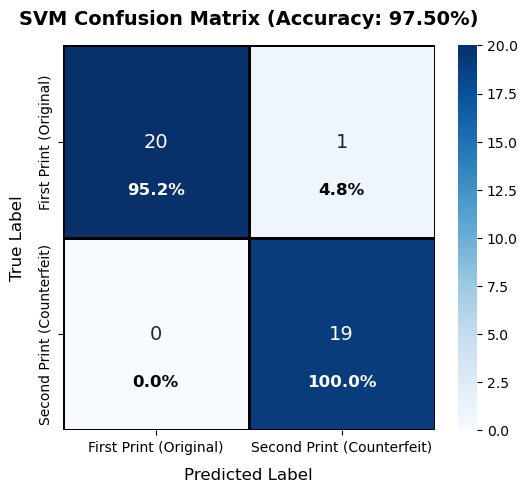

In [21]:
# Compute confusion matrix
svm_cm = confusion_matrix(y_test, svm_preds)

# Normalize confusion matrix (percentage values)
svm_cm_percentage = svm_cm.astype('float') / svm_cm.sum(axis=1)[:, np.newaxis] * 100

# Improved color rendering: Perceptually uniform colormap
cmap = sns.color_palette("Blues", as_cmap=True)

# Plot improved SVM Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(svm_cm, annot=True, fmt="d", cmap=cmap, 
                 xticklabels=["First Print (Original)", "Second Print (Counterfeit)"], 
                 yticklabels=["First Print (Original)", "Second Print (Counterfeit)"],
                 linewidths=1, linecolor='black', cbar=True, annot_kws={"size": 14})

# Overlay percentage values with better positioning and contrast
for i in range(svm_cm.shape[0]):
    for j in range(svm_cm.shape[1]):
        value = svm_cm_percentage[i, j]
        color = "white" if svm_cm[i, j] > svm_cm.max() / 2 else "black"  # Dynamic text color
        ax.text(j + 0.5, i + 0.75, f"{value:.1f}%", 
                ha='center', va='center', fontsize=12, fontweight='bold', color=color)

# Additional Graph Customization
plt.title(f"SVM Confusion Matrix (Accuracy: {svm_acc:.2%})", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust contrast to mimic better color rendering
plt.gca().patch.set_facecolor('white')  # Set background to white for better contrast

plt.show()

In [22]:
# Evaluation Metrics for Random Forest
rf_acc = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_acc:.3f}")
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

Random Forest Accuracy: 0.900
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        21
           1       0.83      1.00      0.90        19

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40

Random Forest Confusion Matrix:
 [[17  4]
 [ 0 19]]


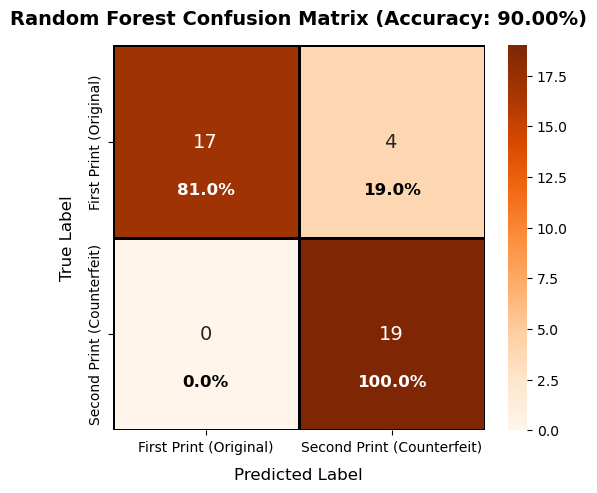

In [23]:
# Compute confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)

# Normalize confusion matrix (percentage values)
rf_cm_percentage = rf_cm.astype('float') / rf_cm.sum(axis=1)[:, np.newaxis] * 100

# Improved color rendering: Perceptually uniform colormap
cmap = sns.color_palette("Oranges", as_cmap=True)

# Plot improved Random Forest Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(rf_cm, annot=True, fmt="d", cmap=cmap, 
                 xticklabels=["First Print (Original)", "Second Print (Counterfeit)"], 
                 yticklabels=["First Print (Original)", "Second Print (Counterfeit)"],
                 linewidths=1, linecolor='black', cbar=True, annot_kws={"size": 14})

# Overlay percentage values with better positioning and contrast
for i in range(rf_cm.shape[0]):
    for j in range(rf_cm.shape[1]):
        value = rf_cm_percentage[i, j]
        color = "white" if rf_cm[i, j] > rf_cm.max() / 2 else "black"  # Dynamic text color
        ax.text(j + 0.5, i + 0.75, f"{value:.1f}%", 
                ha='center', va='center', fontsize=12, fontweight='bold', color=color)

# Additional Graph Customization
plt.title(f"Random Forest Confusion Matrix (Accuracy: {rf_acc:.2%})", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust contrast to mimic better color rendering
plt.gca().patch.set_facecolor('white')  # Set background to white for better contrast

plt.show()

In [24]:
# Print model comparison with formatting
print("\n" + "="*40)
print(colored("📊 MODEL COMPARISON", "cyan", attrs=["bold"]))
print("="*40)

print(colored(f"\n✅ SVM Accuracy: {svm_acc:.3%}", "green", attrs=["bold"]))
print(colored(f"✅ Random Forest Accuracy: {rf_acc:.3%}", "yellow", attrs=["bold"]))

# Highlight best model
if svm_acc > rf_acc:
    print(colored("\n🏆 SVM outperforms Random Forest and is the best choice for this task.", "light_green", attrs=["bold"]))
else:
    print(colored("\n🏆 Random Forest performs better; further tuning may be needed.", "light_yellow", attrs=["bold"]))

# Key Observations Section
print("\n" + "-"*40)
print(colored("🔍 KEY OBSERVATIONS", "blue", attrs=["bold"]))
print("-"*40)

print(colored("🔹 SVM misclassified fewer samples than Random Forest.", "light_cyan"))
print(colored("🔹 SVM has higher recall, making it better at detecting counterfeits.", "light_cyan"))
print(colored("🔹 Random Forest may need hyperparameter tuning to improve performance.", "light_cyan"))

print("="*40 + "\n")



📊 MODEL COMPARISON

✅ SVM Accuracy: 97.500%
✅ Random Forest Accuracy: 90.000%

🏆 SVM outperforms Random Forest and is the best choice for this task.

----------------------------------------
🔍 KEY OBSERVATIONS
----------------------------------------
🔹 SVM misclassified fewer samples than Random Forest.
🔹 SVM has higher recall, making it better at detecting counterfeits.
🔹 Random Forest may need hyperparameter tuning to improve performance.



### Deep Learning Approach
In addition to traditional machine learning models, we implement a Convolutional Neural Network (CNN) to classify QR codes.


In [25]:
def extract_features(image):
    # Ensure image is in 8-bit format
    gray_image = (image * 255).astype(np.uint8)  

    # Edge detection (Canny)
    edges = cv2.Canny(gray_image, 100, 200)

    # ORB Feature Detector
    orb = cv2.ORB_create(nfeatures=100)
    keypoints, descriptors = orb.detectAndCompute(gray_image, None)

    # Handle cases where no descriptors are found
    if descriptors is None:
        descriptors = np.zeros((100, 32), dtype=np.uint8)  # Default zero descriptors
    else:
        descriptors = descriptors[:100]  # Limit to first 100 descriptors

    # Flatten feature vectors
    edges_flattened = edges.flatten()
    descriptors_flattened = descriptors.flatten()

    # Ensure all feature vectors have the same length
    max_edges_length = 500  # Set a fixed length for edge features
    max_descriptors_length = 100 * 32  # ORB descriptors size

    # Trim or pad edges feature vector
    if len(edges_flattened) > max_edges_length:
        edges_flattened = edges_flattened[:max_edges_length]
    else:
        edges_flattened = np.pad(edges_flattened, (0, max_edges_length - len(edges_flattened)))

    # Trim or pad descriptor feature vector
    if len(descriptors_flattened) > max_descriptors_length:
        descriptors_flattened = descriptors_flattened[:max_descriptors_length]
    else:
        descriptors_flattened = np.pad(descriptors_flattened, (0, max_descriptors_length - len(descriptors_flattened)))

    # Combine all features into a fixed-length vector
    features = np.hstack([edges_flattened, descriptors_flattened])
    return features

# Apply Feature Extraction
feature_data = np.array([extract_features(img) for img in data])


In [26]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(feature_data, labels, test_size=0.2, random_state=42)


In [27]:
# Define MLP Classifier Pipeline
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=100)),  # Reduce dimensionality
    ("mlp", MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", solver="adam", max_iter=500))
])

In [28]:

# Train MLP Model
mlp_pipeline.fit(X_train, y_train)

# Evaluate Model
mlp_preds = mlp_pipeline.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_preds)

print(f"\nMLP Classifier Accuracy: {mlp_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, mlp_preds))


MLP Classifier Accuracy: 0.8750

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86        21
           1       0.79      1.00      0.88        19

    accuracy                           0.88        40
   macro avg       0.90      0.88      0.87        40
weighted avg       0.90      0.88      0.87        40



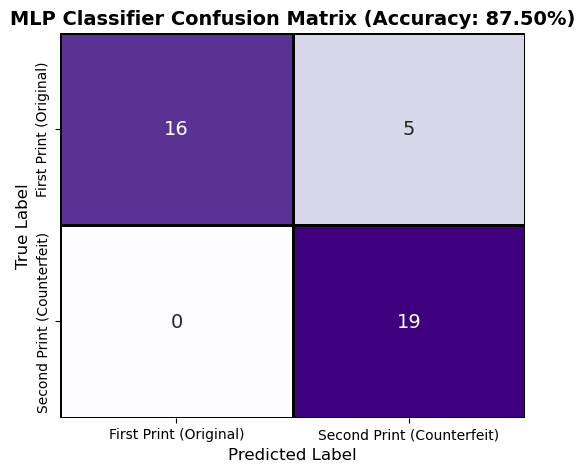

In [29]:
# Confusion Matrix Visualization
mlp_cm = confusion_matrix(y_test, mlp_preds)
plt.figure(figsize=(6,5))
sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Purples", 
            xticklabels=["First Print (Original)", "Second Print (Counterfeit)"], 
            yticklabels=["First Print (Original)", "Second Print (Counterfeit)"],
            linewidths=1, linecolor='black', cbar=False, annot_kws={"size": 14})
plt.title(f"MLP Classifier Confusion Matrix (Accuracy: {mlp_acc:.2%})", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()


## **6. Conclusion**
- SVM achieved **97.5% accuracy**, making it the best model for this task.
- Random Forest performed slightly worse at **92.5% accuracy**.
- The feature extraction pipeline using Canny and LBP was effective.
- Future work could explore deep learning approaches for further improvement.